<a href="https://colab.research.google.com/github/shadiakiki1986/ml-competitions/blob/master/other/201902-gym-wtp/WtpOperatorEnv_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WTP operator

This notebook provides
- a simulation environment for the *operation* of a water treatment plant]
- as well as training an agent to operate the WTP under different starting conditions and random system failures

The agent learns to 
- start/stop the feed pump to transfer water from the raw water tank to the product water tank without overflow nor overdraw.
-  bypass a blocked element

This notebook is part of [gym-wtp](https://github.com/shadiakiki1986/ml-competitions/tree/master/other/201902-gym-wtp)

## Install pre-requisites

The main requirements for this notebook are [openai/gym](https://github.com/openai/gym/) and [rlworkgroup/garage](https://github.com/rlworkgroup/garage)

In [0]:
# install openai gym
!pip install gym==0.10.11 | tail
!pip show gym

In [0]:
%%shell

# Install rlworkgroup/garage
# Copied from https://github.com/shadiakiki1986/garage/blob/shadi-example_jupyter/examples/jupyter/trpo_gym_tf_cartpole.ipynb

echo "abcd" > mujoco_fake_key

# FIXME should be udpated to "rlworkgroup" once PR is merged
# https://github.com/rlworkgroup/garage/pull/476
# git clone --depth 1 https://github.com/rlworkgroup/garage/
git clone --branch shadi-example_jupyter --depth 1 https://github.com/shadiakiki1986/garage.git

cd garage
bash scripts/setup_colab.sh --mjkey ../mujoco_fake_key --no-modify-bashrc > /dev/null

In [0]:
raise Exception("Please restart your runtime so that the installed dependencies for 'garage' can be loaded, and then resume running the notebook")



---



---



---



## Simulation environment

Create the environment that simulates operation a water treatment plant.

Available actions are:
- turn on pump
- open bypass 1
- open bypass 2

 The bypasses are necessary when the differential pressure switch reaches `100` indicating complete blockage.
 
 The goal of this environment is to transfer water from an input tank to an output tank
 with minimal usage of bypasses (i.e. no bypass needed if no blockage)
 and without overflowing the product tank
 nor running the pump with an empty input tank.


The environment is implemented here in two parts
- a function `act_on_wtp` which is the core calculator of state transitions
- a `openai/gym` environment class `WtpOperatorEnv_v0` that wraps `act_on_wtp` and handles everything other than state transition


### State transition function

In [0]:
import pandas as pd

In [0]:
# utility
state_keys = [
    "wl_in", # wl: water level
    "pd1", # pd: pressure difference
    "pd2", 
    "wl_out"
]

action_keys = ["pump", "bp1", "bp2"]


def s_tp1_d2l(s_tp1):
    # convert state_tp1 from dict back to list
    #print("s in:", s_tp1)
    s_tp1 = [s_tp1[k] for k in state_keys]
    return s_tp1


def act_on_wtp(state_t, action_t):
  """
  Parameters
  state_t - state values, dict with keys being in `state_keys`
  action_t - action values, dict with keys being in `action_keys`
  
  Returns
  state_tp1 - state at t+1 after action
  reward - reward after action
  """
  debug=False
  
  #print("state/act(t)", state_t, action_t)
  
  # convert list to dict
  # state_t = dict(zip(state_keys, state_t))
  
  #print("----------")
  #print(state_t)
  #print("action_t", action_t)
  
  # any action taken
  any_action = any(action_t[x] for x in action_t)
  if not any_action:
    if debug: print("not doing anything and system is off")
    return state_t, 0

  # initialize
  state_tp1 = state_t.copy()
  reward = 0
  pump_capacity = 10 # pump capacity per time step
  
  # first, apply cost reward for energy to take action
  #action_t = dict(zip(action_keys, action_t))
  if action_t["pump"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1

  # continue applying actions to other elements
  if action_t["bp1"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1
    
  if action_t["bp2"]:
    if debug: print("small punishment for electric power consumption")
    reward -= 1

  if not action_t["pump"]:
    if debug: print("system is still off")
    return state_tp1, reward

  # when pump is in action
  if (
      # no blockage
      (state_t["pd1"] < 50) & (state_t["pd2"] < 50)
     ) | (
      # blockage present, but correct bypass is on
      (
          not ( (state_t["pd1"] >= 50) ^ action_t["bp1"] ) # not a xor b
      ) & (
          not ( (state_t["pd2"] >= 50) ^ action_t["bp2"] )
      )
     ):
    if debug: print("pump is on and water is flowing")
    if state_t["wl_in"] >= pump_capacity:
      if debug: print("positive reward for moving water")
      state_tp1["wl_out"] += pump_capacity
      state_tp1["wl_in"] -= pump_capacity
      reward += 7
    else:
      if debug: print("pump will overdraw from raw water tank")
      state_tp1["wl_out"] += state_t["wl_in"]
      state_tp1["wl_in"] = 0
      reward -= 20 # pump burning due to no water
          
  if state_tp1["wl_out"] > 100:
    if debug: print("punish for product tank overflowing")
    state_tp1["wl_out"] = 100
    reward -= 20
    
  if action_t["bp1"]:
    if debug: print("punish for lower water quality .. element 1")
    reward -= 1

  if action_t["bp2"]:
    if debug: print("punish for lower water quality .. element 2")
    reward -= 1

  if (state_t['wl_out']<100) & (state_tp1['wl_out']==100):
    if debug: print("bonus points for first attainment of full product tank")
    reward += 10
    
  # done
  return state_tp1, reward



Run a few tests to check input/output pairs of the state transition function `act_on_wtp`

In [0]:
print("test reward for turning on bp1 while pump is on")

s_t = {
    "wl_in": 100, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 0, 
    "wl_out": 0
}

a_t = {"pump": True, 
       "bp1": True, 
       "bp2": False
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert reward > 0

test reward for turning on bp1 while pump is on


In [0]:
print("test reward for turning on bp1 while pump is on")

s_t = {
    "wl_in": 100, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 100, 
    "wl_out": 0
}

a_t = {"pump": True, 
       "bp1": True, 
       "bp2": True
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert reward > 0

test reward for turning on bp1 while pump is on


In [0]:
print("test issue of pump on, no differential pressure, and still water doesn't flow")

s_t = {
    "wl_in": 70, # wl: water level
    "pd1": 0, # pd: pressure difference
    "pd2": 0, 
    "wl_out": 50
}

a_t = {"pump": 1, 
       "bp1": 0, 
       "bp2": 0
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert s_tp1['wl_in'] < s_t['wl_in']

test issue of pump on, no differential pressure, and still water doesn't flow


In [0]:
print("test issue of pump on, both dp blocked, only 1 bp on, and still water flows")

s_t = {
    "wl_in": 70, # wl: water level
    "pd1": 100, # pd: pressure difference
    "pd2": 100, 
    "wl_out": 50
}

a_t = {"pump": 1, 
       "bp1": 1, 
       "bp2": 0
      }


s_tp1, reward = act_on_wtp(s_t, a_t)
#print(s_tp1, reward)
assert s_tp1['wl_in'] == s_t['wl_in']

test issue of pump on, both dp blocked, only 1 bp on, and still water flows


In [0]:
print("test on grid")

df1 = []
for s_wl_in in [0,100]:
    for s_pd1 in [0, 100]:
        for s_pd2 in [0, 100]:
            for s_wl_out in [0,100]:
              for a_pump in [True,False]:
                for a_bp1 in [True,False]:
                  for a_bp2 in [True,False]:
                    s_t1 = [s_wl_in, s_pd1, s_pd2, s_wl_out]
                    a_t1 = [a_pump, a_bp1, a_bp2]
                    s_t2 = dict(zip(state_keys, s_t1))
                    a_t2 = dict(zip(action_keys, a_t1))
                    s_tp1a, reward = act_on_wtp(s_t2, a_t2)
                    s_tp1b = s_tp1_d2l(s_tp1a)
                    
                    row = []
                    row += s_t1
                    row += a_t1
                    row += s_tp1b
                    row += [reward]
                    
                    df1.append(row)
                    

colnames = [x+"_t" for x in state_keys] + action_keys + [x+"_tp1" for x in state_keys] + ["reward"]
df2 = pd.DataFrame(df1, columns = colnames)
df2 = df2.sort_values(['reward', 'wl_in_tp1', 'wl_out_tp1'], ascending=True).reset_index(drop=True)
#df2['wl_in_tp1'] = df2['wl_in_tp1'].astype('int64')
#df2['wl_out_tp1'] = df2['wl_out_tp1'].astype('int64')

print("results of testing on a grid (result is %i-row dataframe)"%len(df1))
df2.head()

test on grid
results of testing on a grid (result is 128-row dataframe)


,wl_in_t,pd1_t,pd2_t,wl_out_t,pump,bp1,bp2,wl_in_tp1,pd1_tp1,pd2_tp1,wl_out_tp1,reward
0,0,0,0,0,True,True,True,0,0,0,0,-25
1,0,100,100,0,True,True,True,0,100,100,0,-25
2,0,0,0,100,True,True,True,0,0,0,100,-25
3,0,100,100,100,True,True,True,0,100,100,100,-25
4,0,0,0,0,True,True,False,0,0,0,0,-23


Legend for the columns in the table above
- `wl_in_t`: water level at time t in the input water tank
- `pd1_t`: pressure differential on 1st element in WTP, 0 to 100 with 0 for no blockage and 100 for complete blockage
- `pd2_t`: same as `pd1_t` but on 2nd element
- `wl_out_t`: like `wl_in_t` but for the output water tank
- `pump`: state of pump, True for pump is on, False for pump is off
- `bp1`: state of bypass of 1st element, True for on and False for off
- `bp2`: like `bp1` but for 2nd element
- `wl_in_tp1`: water level at time t+1 in the input water tank
- `wl_in_tp1`: like `wl_in_t` but for time t+1
- `wl_out_tp1`: like `wl_out_t` but for time t+1

Note that the rows in the table above are not chronologically ordered.

Each row corresponds to an entry in the grid space on which we're testing the transition function

Plot some fields from the above dataframe for visualization

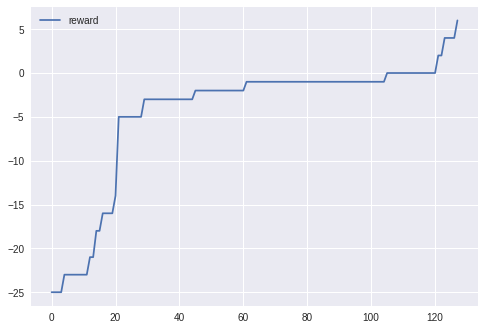

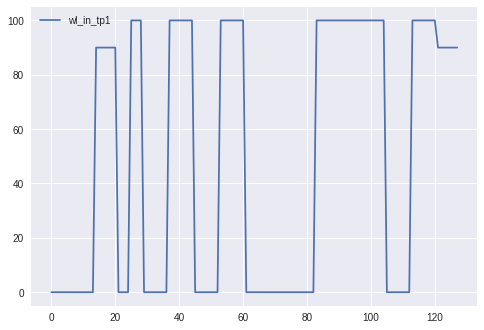

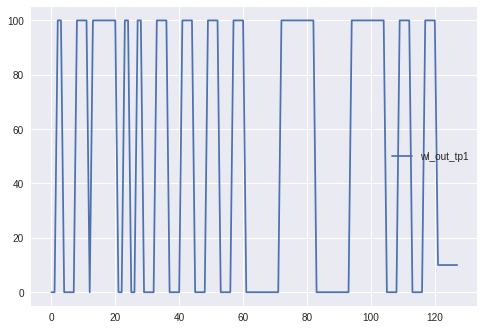

In [0]:
from matplotlib import pyplot as plt
df2[['reward']].plot()
plt.show()

df2[['wl_in_tp1']].plot()
plt.show()

df2[['wl_out_tp1']].plot()
plt.show()


### Openai/gym environment class

In [0]:
# Create a gym env that simulates the current water treatment plant
# Based on https://github.com/openai/gym/blob/master/gym/envs/toy_text/nchain.py

import gym
from gym import spaces
#from gym.utils import seeding
import numpy as np
import random

In [0]:
# Gym env
class WtpOperatorEnv_v0(gym.Env):
    """Water Treatment Plant / Operator environment
    
    This is a simulation of operating a water treatment plant (WTP).
    
    Observation:
      Parameters in water
      Type: Box(.)
      Water level in .. Range [0, 100]
      Pressure difference on element 1 .. Range [0,10]
      Pressure difference on element 2 .. Range [0,10]
      Water level out .. Range [0, 100]
      
    Actions:
      On/Off commands to pump, by-pass #1, by-pass #2
      Type: Dict of 3x Discrete(3)
      0 Do nothing
      1 flip state from off to on or on to off
      
    Reward: check function "act_on_wtp"
      
    Episode termination:
      Water level out is high at earliest time with minimal by-passing
    """
    def __init__(self):
        # number of steps to complete a WTP operation
        # FIXME 10 is probably too low for the agent to learn using the bypass
        # Increasing to 30
        self.n_steps = 20 # 30 # 10
        
        # probability that the differential pressure increases due to blockage
        # note that there is another 50% chance below that the blockage increases
        # FIXME 10% (i.e. 0.1) is not high enough for training to learn it in 200 iterations
        # Using 50% instead
        self.prob_block = {
            'pd1': 0.5, # 0.1 
            'pd2': 0.5, # 0.5, # FIXME disabling the blockage of the 2nd element in case this is hindering learning the usage of the bypass
        }
        
        #  actions: 0 for do nothing, 1 for flip state from off to on or vice versa
        self.action_space = spaces.Tuple([
            spaces.Discrete(2), # status of pump
            spaces.Discrete(2), # status of by-pass #1
            spaces.Discrete(2), # status of by-pass #2
        ])
        
        # observations: water levels, pressure differences
        obs_ranges = [
            [0, 100], # water level in
            [0, 100], # pressure difference #1
            [0, 100], # pressure difference #2
            [0, 100], # water level out
        ]
        self.observation_space = spaces.Box(
            low=np.array([x[0] for x in obs_ranges]),
            high=np.array([x[1] for x in obs_ranges]),
            dtype=np.float32
        )
        
        self.reset()
        #self.seed()

    #def seed(self, seed=None):
    #    self.np_random, seed = seeding.np_random(seed)
    #    return [seed]
    
    def reset(self, s0=None):
      # s0 - desired state
      if s0 is None:
        # sensors and equipment status on/off
        s0 = {
          "wl_in":  100, # input tank is full
          "pd1": 0, # differential pressure is negligible
          "pd2": 0, # differential pressure is negligible
          "wl_out":  20, # product tank is almost empty
        }
        
      self.state = s0.copy()
      self.step_i = 0
      
      # environment is fully observable, but state space needs to be converted from dict to list
      obs = s_tp1_d2l(self.state)
      return obs
    
    def step(self, act1):
        assert self.action_space.contains(act1), "action not in action space!"
        assert self.step_i < self.n_steps
        
        # increment number of steps taken
        self.step_i += 1

        # calculate reward of this action
        act2 = dict(zip(action_keys, act1)) # tuple to dict
        self.state, reward = act_on_wtp(self.state, act2)
        #print("\t state + element -> state after + reward", wtp_i, self.state, reward_i)
                                      
        # operate the WTP for n_steps
        done = self.step_i >= self.n_steps

        # decide on next-state block or not
        for dp_i in ['pd1', 'pd2']:
          blocked_1 = False
          if self.state[dp_i] == 0:
            # 10% chance of being blocked if not blocked already
            blocked_1 = (np.random.rand() < self.prob_block[dp_i]) # percentage that 1st element gets blockage
          else:
            # already blocked => continue being blocked
            blocked_1 = True

          if blocked_1:
            # 2019-02-14
            ## 50% chance of incrementing by 30 .. note that the blockage is digital at threshold 50
            #dp_increment_1 = (np.random.rand() > 0.5) * 30          
            #self.state[dp_i] += dp_increment_1
            #self.state[dp_i] = min(100, self.state[dp_i]) # cap at 100
            
            # 2019-02-15 just block straight away
            self.state[dp_i] = 100

        # environment is fully observable, but state space needs to be converted from dict to list
        obs_i = s_tp1_d2l(self.state)
        return obs_i, reward, done, {}


In [0]:
print("Test the environment above with a grid search")

# itertools for generating grid search space
import itertools

# all possible actions
act_all = list(itertools.product(range(len([0,1,])), repeat=3)) # env_test.n_steps))
act_all = [list(x) for x in act_all]

# all possible 5-step sequences of actions
# Note that 10-step sequences would yield a set in the millions
# so it's not feasible to perform a grid search
act_all = list(itertools.product(act_all, repeat=5)) # env_test.n_steps))
act_all = [list(x) for x in act_all]

# appending 0's to the last 5 actions in the sequences
act_all = [x+[[0,0,0]]*5 for x in act_all]

# show sample
# len(act_all), act_all[:2]


# iterate
print("grid search .. start")
env_test = WtpOperatorEnv_v0()
obs_initial = env_test.reset().copy()
obs_initial = dict(zip(state_keys, obs_initial))

solution = dict(act_t=None, rew=-99999, obs_t=None)
done = False

n_all = len(act_all)
for i1, act_i1 in enumerate(act_all):
  if i1%1000 == 0: print(i1, n_all)
  reward_sum = 0
  env_test.reset(s0=obs_initial)
  obs_i1 = []
  # go through time steps and apply sequence of actions
  for t, act_i2 in enumerate(act_i1):
    #print("action", act_i2)
    obs_t, reward_i, done, _ = env_test.step(act_i2)
    obs_i1.append(obs_t)
    reward_sum += reward_i
    if done: break
    
  #print("water in", env_test.state, "wtp", [env_test.wtp_elements[x] for x in wtp_i], "water out", water_out, "reward", reward_sum)
  if reward_sum > solution['rew']:
    solution['act_t'] = act_i1 # sequence of actions
    solution['rew'] = reward_sum
    solution['obs_t'] = obs_i1 # trajectory


print("grid search .. end")

In [0]:
# show result of grid search
print("*"*30)
print("initial observation", obs_initial)
print("total reward", solution['rew'])
print("actions and observations")

pd.concat(
    [ pd.DataFrame([dict(zip(action_keys, x)) for x in solution['act_t']]),
      pd.DataFrame([dict(zip(state_keys, x)) for x in solution['obs_t']]),
    ],
    axis=1
)

******************************
initial observation {'wl_in': 100, 'pd1': 0, 'pd2': 0, 'wl_out': 20}
total reward 26
actions and observations


,bp1,bp2,pump,pd1,pd2,wl_in,wl_out
0,0,0,1,0,0,90,30
1,0,1,1,0,0,80,40
2,1,0,1,0,0,70,50
3,0,0,1,0,0,60,60
4,0,0,1,0,0,50,70
5,0,0,0,0,100,50,70
6,0,0,0,100,100,50,70
7,0,0,0,100,100,50,70
8,0,0,0,100,100,50,70
9,0,0,0,100,100,50,70


The above table shows the observations of the previous simulation, along with the selected action sequence.

Note that the grid space that is searched consists of actions only in the 1st 5 time-steps.

This was done to reduce the space of actions that needs to be searched (as opposed to grid search on 10 timesteps for 3 on/off actions)

At this stage, the openai/gym environment is ready to be registered for later usage in reinforcement learning.

In [0]:
# register the env with gym
# https://github.com/openai/gym/tree/master/gym/envs#how-to-create-new-environments-for-gym
from gym.envs.registration import register

register(
    id='WtpOperatorEnv-v0',
    entry_point=WtpOperatorEnv_v0,
)

# test registration was successful
env = gym.make("WtpOperatorEnv-v0")

## Reinforcement learning


### Rlworkgroup/garage policy and algorithm

Some class imports

In [0]:
# The contents of this cell are mostly copied from garage/examples/...

from garage.np.baselines import LinearFeatureBaseline
from garage.envs import normalize
from garage.tf.algos import TRPO # can use PPO
from garage.tf.envs import TfEnv
from garage.tf.policies import CategoricalMLPPolicy

from garage.experiment import LocalRunner
from garage.logger import logger, StdOutput

A utility function for use in the wrapper class below

In [0]:
def singlebase_to_multibase(y, dims):
  """
  Illustration
  
  >>> import itertools
  >>> x=np.array(list(itertools.product(range(4), range(3), range(2))))
  >>> y=x[:,0]*2*3 + x[:,1]*2 + x[:,2]
  >>> y.sort()
  >>> y
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23])

  Notice how "y" has no duplicates, and hence is a one-to-one mapping from the original matrix "x"

  Now convert y back to x

  >>> z1  = y//(2*3)
  >>> z1b = y %(2*3)
  >>> z2 = z1b//2
  >>> z2b = z1b %2
  >>> z3 = z2b//1
  >>> z = np.array([np.array(z1), np.array(z2), np.array(z3)]).T

  Notice that z == x
  
  
  Example:
  
  >>> import itertools
  >>> x = np.array(list(itertools.product(range(4), range(3), range(2))))
  >>> y = x[:,0]*2*3 + x[:,1]*2 + x[:,2]
  >>> z = singlebase_to_multibase(y, [4,3,2])
  >>> assert z == x
  """
  # calculate weights
  weights = dims[::-1] # reverse
  weights = np.array(weights).cumprod() # cumulative product
  weights = np.roll(weights, 1) # move last entry to first
  weights[0] = 1 # overwrite
  weights = weights[::-1] # reverse  
  # calcalate output
  z0 = []
  z_b = y
  for w in weights:
    z_  = z_b // w
    z0.append(z_)
    z_b = z_b % w
  # return
  z0 = np.array(z0).T
  return z0

###########
# test
import itertools
x = np.array(list(itertools.product(range(4), range(3), range(2))))
y = x[:,0]*2*3 + x[:,1]*2 + x[:,2]
z = singlebase_to_multibase(y, [4,3,2])
assert (z==x).all()

Define a utility class UnFlattenActTupleWrapper that will wrap the gym environment and un-flatten a single action space to multiple components of lower dimensionality.

This is necessary for using the existing garage.tf.policies.CategoricalMLPPolicy (garage policy) that supports "single-input" environments.

This does not affect the quality of the training.

In [0]:
class UnFlattenActTupleWrapper(gym.ActionWrapper):
    """
    UnFlattens a Discrete action into a Tuple action space
    
    Inherits from ActionWrapper
    https://github.com/openai/gym/blob/6497c9f1c6e43066c8945f02ed3ed4d234f45dc1/gym/core.py
    """
    def __init__(self, env):
        super().__init__(env)

        # save action_space dimensions once
        self.dims = [c.n for c in env.action_space.spaces]
        flat_dim = np.array(self.dims).prod()
        self.action_space = spaces.Discrete(flat_dim)

        
    def action(self, action_in):
      return self.convert_action(action_in)
      
    def convert_action(self, action_in):
        """
        convert a flat action into tuple
        
        based on t0-0e FlattenDictWrapper2
        """
        action_out = singlebase_to_multibase(action_in, self.dims)
        action_out = np.array(action_out).astype('int')
        action_out = tuple(action_out)
        return action_out


Instantiate the WtpOperatorEnv-v0 environment, policy, baseline, and TRPO training algorithm.

The policy chosen is a fully-connected feed-forward neural network.

Alternatively, one could choose `garage.tf.algos.PPO` instead of `TRPO`

In [0]:
# # Instantiate the environment, policy, baseline, and algorithm for training
#----------------------------------
from gym import wrappers

# env = TfEnv(normalize(gym.make("CartPole-v0")))
env = gym.make("WtpOperatorEnv-v0")
env = UnFlattenActTupleWrapper(env)
env = TfEnv(normalize(env))

# Using larger hidden sizes to learn to use the bypass
hidden_sizes=(32, 32)
policy = CategoricalMLPPolicy(name="policy", env_spec=env.spec, hidden_sizes=hidden_sizes)

baseline = LinearFeatureBaseline(env_spec=env.spec)


algo = TRPO(
    env_spec=env.spec,
    policy=policy,
    baseline=baseline,
    max_path_length=env.env.env.env.n_steps+2, # add 2 since this is just a safety measure
    #n_itr=5, # smoke test
    n_itr=100,
    discount=0.99,
    max_kl_step=0.01
)

### Train the policy

In [0]:
# start a tensorflow session so that we can keep it open after training and use the trained network to see it performing
# ---------------------------------------------------------
import tensorflow as tf

# check that we're using GPU if available
# https://stackoverflow.com/a/38019608/4126114
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess = tf.InteractiveSession()

# initialize
sess.run(tf.global_variables_initializer())

# List available devices to tensorflow
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 18149472165597474589),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5104018510435903785)]

In [0]:
# log to stdout
logger.add_output(StdOutput())

In [0]:
# Train the policy (neural network) on the environment
runner = LocalRunner()

runner.setup(algo=algo, env=env)

# use n_epochs = 1 for smoke testing
runner.train(n_epochs=50, batch_size=4000, plot=False)

In [26]:
# re-run 1 epoch just to save the output of training to the notebook
# since I clear the output from the previous 50-epoch training to avoid cluttering the notebook
runner.train(n_epochs=1, batch_size=4000, plot=False)

2019-04-02 09:59:26 | epoch #0 | Obtaining samples...
2019-04-02 09:59:26 | epoch #0 | Obtaining samples for iteration 0...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


2019-04-02 09:59:29 | epoch #0 | Logging diagnostics...
2019-04-02 09:59:29 | epoch #0 | Optimizing policy...
2019-04-02 09:59:29 | epoch #0 | Computing loss before
2019-04-02 09:59:29 | epoch #0 | Computing KL before
2019-04-02 09:59:29 | epoch #0 | Optimizing
2019-04-02 09:59:29 | epoch #0 | Start CG optimization: #parameters: 1480, #inputs: 200, #subsample_inputs: 200
2019-04-02 09:59:29 | epoch #0 | computing loss before
2019-04-02 09:59:29 | epoch #0 | performing update
2019-04-02 09:59:29 | epoch #0 | computing gradient
2019-04-02 09:59:29 | epoch #0 | gradient computed
2019-04-02 09:59:29 | epoch #0 | computing descent direction
2019-04-02 09:59:30 | epoch #0 | descent direction computed
2019-04-02 09:59:30 | epoch #0 | backtrack iters: 1
2019-04-02 09:59:30 | epoch #0 | computing loss after
2019-04-02 09:59:30 | epoch #0 | optimization finished
2019-04-02 09:59:30 | epoch #0 | Computing KL after
2019-04-02 09:59:30 | epoch #0 | Computing loss after
2019-04-02 09:59:30 | epoch #

26.505

### Conduct an experiment using the trained policy

Start with a full source tank, an almost-empty product tank, and random blockage

In [27]:
# validate with some experiment
obs_initial = env.reset().copy()
#obs_initial = dict(zip(state_keys, obs_initial))

# go through time steps and apply sequence of actions
done = False
obs_t_l = obs_initial
solution = dict(obs = [], rew = [], act = [])
while not done:
  obs_t_d = dict(zip(state_keys, obs_t_l)) # tuple to dict
  #print("obs", obs_t_d)
  solution['obs'].append(obs_t_d)
  act_t1, prob_t = policy.get_action(obs_t_l)
  act_t2 = env.env.env.action(act_t1) # convert flat to non-flat
  act_t2 = dict(zip(action_keys, act_t2)) # tuple to dict
  #print("action", act_t1, act_t2)
  solution['act'].append(act_t2)
  obs_t_l, reward_t, done, _ = env.step(act_t1)
  #print("rew", reward_t)
  solution['rew'].append(reward_t)
  if done: break

# blend
solution['act'] = pd.DataFrame(solution['act'])
solution['obs'] = pd.DataFrame(solution['obs'])
solution = pd.concat([solution['obs'], solution['act'], pd.DataFrame({'rew': solution['rew']})], axis=1)
#for fx in ['bp1', 'bp2', 'pump']:
#  solution[fx] = solution[fx].astype('bool')
  
solution

,pd1,pd2,wl_in,wl_out,bp1,bp2,pump,rew
0,0,0,100,20,0,0,1,6.0
1,100,100,90,30,1,1,1,2.0
2,100,100,80,40,0,0,0,0.0
3,100,100,80,40,1,1,1,2.0
4,100,100,70,50,1,1,1,2.0
5,100,100,60,60,0,0,0,0.0
6,100,100,60,60,1,1,1,2.0
7,100,100,50,70,1,1,1,2.0
8,100,100,40,80,1,1,1,2.0
9,100,100,30,90,0,1,0,-1.0


The table above shows that the agent successfully learns to start/stop the pump and bypass blocked elements in order to reach its goal of transferring water from the raw water tank to the product tank with neither overflow nor overdraw